In [120]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime

# Detecting bot signups in the Channel

We are working with three datasources, about the bot registration, the telegram channel community and timestamped join log data from the AmaZix channel bot. 

The goal is to identify pattern in the data we can use to manually label a given user signup to be a likely bot, and ban them from the channel, and exclude them 
from receiving token from the airdrop. 

This boils down to two seperate problems:
* Clearly identifying the bot signups in the process of token airdrop registration and excluding them from the token drop
* Marking users to be excluded from the channel based on beeing a bot

What the analysis has shown:

* We can exlude a large number of users based on incomplete registration from the token process
* There are accounts registered to a set of non-unique wallet addresses, which can be directly baned from the drop and channel
* There
 

In [121]:
# Loading the Data
df_channel = pd.read_csv("./datasources/DREAMToken_Channel_userlist.csv")
df_signups = pd.read_csv('./datasources/telegram_data-ChatbotSignups.csv')
df_channel_joins = pd.read_csv("./datasources/dream-joins-2018-07-24.csv")

In [122]:
print("We have {} entries from the channel joins dataset by AmaZix".format(len(df_channel_joins)))
print("We have {} entries from the channel user dataset from the crawler".format(len(df_channel)))
print("We have {} entries from the Bot signup dataset from Indorse".format(len(df_signups)))

We have 75114 entries from the channel joins dataset by AmaZix
We have 95340 entries from the channel user dataset from the crawler
We have 103663 entries from the Bot signup dataset from Indorse


#### Data Preprocessing

In [123]:
# Preprocessing - CHANNEL BOT JOIN DATA
df_channel_joins.columns.values[0] = "joined_channel_at"
df_channel_joins.columns.values[1] = "telegram_id"

# Preprocessing - BOT SIGNUP DATA

df_signups
df_signups['email_provider'] = df_signups['email'].str.split("@").str.get(1)
df_signups['email_name'] = df_signups['email'].str.split("@").str.get(0)
# Preprocess the data types
df_signups['timestamp'] = pd.to_datetime(df_signups['timestamp'])
df_signups.columns.values[0] = "registered_at"


# Preprocessing - CHANNEL SIGNUP DATA

df_channel.columns.values[0] = "telegram_id"
df_channel['last_online'] = pd.to_datetime(df_channel['last_online'])
df_channel['since_last_online'] =  pd.datetime.now() - df_channel['last_online']

# Joining the Dataset

Bringing together  datasets:
* Channel join logs from the AmaZix Bot
* The Telegram Channel Information about the Users currently in the channel
* The Signup Data from the Indorse Bot

into a joined set by telegram_id. We can now analyze additional information about the users.

Things to try here:
* Add a set of columns marking exlusion reasons

In [124]:
# Indexing all datasets on telegram_id
df_channel_idx = df_channel.set_index('telegram_id')
df_signups_idx = df_signups.set_index('telegram_id')
df_channel_joins_idx = df_channel_joins.set_index('telegram_id')

# # Joining the datasets
first_join = df_signups_idx.join(df_channel_joins_idx, rsuffix="__AmaZix", how='left')
df_join = first_join.join(df_channel_idx, rsuffix="__UserInfo", how='left')

# # Subset the dataframe to the information relevant to us
columns= ['registered_at', 'joined_channel_at', 'verified', 'username', 'name','first_name', 
          'last_name', 'email', 'email_name','email_provider','ethaddress', 'deleted', 'is_online', 
          'recently_online','last_online', 'since_last_online']
#Adapt the columns
df_join = df_join[columns]

# Adapt the column types as needed
df_join['joined_channel_at'] = pd.to_datetime(df_join['joined_channel_at'])
df_join['registered_at'] = pd.to_datetime(df_join['registered_at'])

In [125]:
df_join.keys()

Index(['registered_at', 'joined_channel_at', 'verified', 'username', 'name',
       'first_name', 'last_name', 'email', 'email_name', 'email_provider',
       'ethaddress', 'deleted', 'is_online', 'recently_online', 'last_online',
       'since_last_online'],
      dtype='object')

## Findings

We have to be aware if we are working with complete or incomplete information at any point in time.

There will be now two processes:
* 1) Identify and label all signups to be excluded from receiving tokens
* 2) Identify and label all signups that are to be removed from the channel, as they are certainly bots.

These two goals will have to be handles seperately, as we can in many cases not be certain that just because someone failed to be accepted into the registration, they are also a bot

In [126]:
# Generating information on exlusion reasons and appending them to the dataframe

# A general (final) is_banned list that might serve as a target for a learner
df_join['is_banned'] = 0
df_join['exluded_from_airdrop'] = 0
df_join['reason_banned'] = None
df_join['reason_excluded'] = None
df_join['severity_level'] = 0

# Generate Features that are informative about possible bot factors
df_join['suspicious_mail'] = 0
df_join['duplicated_wallet'] = 0
df_join['empty_profile'] = 0
df_join['abbandoned_registration'] = 0 # Mark empty profiles that have registered but have not been verified in the Token Registraion
df_join['never_activated'] = 0 # Marks accounts that have never been active after 5 min from registration / channel join
df_join['period_active_channel'] = df_join['last_online'] - df_join['joined_channel_at'] # The range of time between the last time active and the time registered for the Channel
df_join['period_active_registration'] = df_join['last_online'] - df_join['registered_at'] # Calculates the time between the registration and the last time online in the channel

# Outlier Features
df_join['outlier_registration_time'] = 0 # Marks an account to be in the lowest 5% of registration times (Indicative of beeing a bot?)
df_join['outlier_last_online'] = 0 # Mark the lowest 2.5% of accounts based on the time since they where last online in the group

# Set the registration time difference
df_join['registration_time'] = df_join['registered_at'] - df_join['joined_channel_at']
#Set info about who joined from partner channel
df_join['joined_from_partnerchannel'] = 0
df_join.loc[df_join['registration_time'] < datetime.timedelta(0), "joined_from_partnerchannel"] = 1
df_join.loc[df_join['joined_from_partnerchannel'] == 1, 'registration_time'] = datetime.timedelta(seconds=1) - df_join[df_join['joined_from_partnerchannel'] == 1]['registration_time']

## Banning Users from the Telegram Channel 

Process:

* Create the necessary features to identify bot behavior in the channel data alone (Make sure to disregard missing information from the registration process)
* Ensure that the features are robust towards missing data
* Add the labels to the dataset, to mark users that are to be banned

### Extraction markers

List of reasons to be excluded from the Telegram group:

* Account has not been activate after initial join date, and is in the 5% longest inactive accounts in the channel
* Account has joined during the first phase of the airdrop and has not successfully completed the signup process
* Account has registered but has not been verified
* Account is found to have registerd non-unique wallets

In [127]:
#Implement the banning labeling processes

# 1. Mark suspiciously unattended profiles (missing personal information)
df_join.loc[df_join['name'].isna() & df_join['first_name'].isna() & df_join['last_name'].isna(), 'empty_profile'] = 1

In [128]:
# 2. Mark empty profiles that have registered but have not been verified in the Token Registraion
df_join.loc[(df_join['empty_profile'] == 1) & (df_join['verified'].isna()) & (df_join['registered_at'] != np.NaN), 'abbandoned_registration'] = 1

In [129]:
# 3. Mark profiles as "never_activated" if the account has never been active after 20 min of channel join / registration 
import datetime
df_join.loc[df_join['period_active_registration'] < datetime.timedelta(minutes=60), "never_activated"] = 1
df_join.loc[df_join['period_active_channel'] < datetime.timedelta(minutes=60), "never_activated"] = 1

In [130]:
# 4. "Highly inactive accounts" marked to be in the lowest 25% of the range of values of "since_last_online"
quantile = 0.25 # <--- sets the most inactive accounts to be banned
df_join["since_last_online_normalized"] = (df_join['since_last_online'] - df_join['since_last_online'].mean()) / df_join['since_last_online'].std()
# Calculate the quantile rank of a given account in the activity pattern
df_join.loc[df_join["since_last_online_normalized"] < df_join["since_last_online_normalized"].quantile(quantile), 'outlier_last_online'] = 1

In [131]:
# 5. Mark profiles as "duplicated_wallet"
signups_by_wallet = df_signups.groupby('ethaddress').count()
duplicated_signups = signups_by_wallet[signups_by_wallet['telegram_id'] != 1]
duplicated_wallet_addresses = duplicated_signups.index.to_series()
# Generate a dict of the relevant dataframe for each duplicated record
duplicates_dict = {}
for wallet in duplicated_wallet_addresses:
    subset_df = df_signups[df_signups['ethaddress'] == wallet]
    duplicates_dict[wallet] = subset_df    
# Extract the telegram ids used to register duplicated accounts
telegram_ids = []
for wallet in duplicated_wallet_addresses:
    telegram_ids.append(duplicates_dict[wallet]['telegram_id'].values)
telegram_ids_duplicate_accounts = [id for list in telegram_ids for id in list]
# Mark all associated accounts "duplicate_wallet"
for id in telegram_ids_duplicate_accounts:
    df_join.loc[id, "duplicated_wallet"] = 1

In [132]:
# 6. Mark joins in terms of units of deviation from the median registration time as outliers (set to the 5%th quantile of the distribution)
reg_times = df_join['registration_time']
df_join['registration_time_offset'] = (reg_times - reg_times.median()) / reg_times.std()
# Mark them outliers
df_join.loc[df_join['registration_time_offset'] < df_join['registration_time_offset'].quantile(.15), 'outlier_registration_time'] = 1

### Set level of certainty about banning

This scale reflects our assertion about the likelyhood of someone beeing fake. We can move from level to level based on the amount of users we have to select out of the groups

In [133]:
# 0: Absolute no signs of fakeness :)

# 1 "inactive": Seems uninvolved and has not completed registration (just hanging around)
df_join.loc[df_join['outlier_last_online'] == 1, 'severity_level'] = 1

# 2 "never_activated": Has registered, been marked "never_active" (Bounty account with no engagement with the channel)
df_join.loc[(df_join['outlier_last_online'] == 1) & (df_join['never_activated'] ==1), 'severity_level'] = 2

# 3: Profile is "empty", and is marked as "abbandoned_registration"
df_join.loc[(df_join['empty_profile'] == 1) | (df_join['abbandoned_registration'] == 1), 'severity_level'] = 3

# 4: Verified, Very low registration_time, empty profile, "never_activated"
df_join.loc[(df_join['never_activated'] == 1) | (df_join['outlier_registration_time'] == 1)
            , 'severity_level'] = 4

# 5 : Obvious scam [Duplicate wallet ]
df_join.loc[(df_join['duplicated_wallet'] == 1), 'severity_level'] = 5



# Finalize the assignment of categories
df_join['severity_level'] = df_join['severity_level'].astype('category')

In [134]:
# Display frequency table of all severity levels in the current dataset
df_join.reset_index().groupby('severity_level').count()['telegram_id']

severity_level
0    51921
1    21002
3    10709
4    19424
5      787
Name: telegram_id, dtype: int64

#### Resulting Stats

In [135]:
print("------- Banning from Telegram Channel ---------------\nThe following features have been applied to the given datasets, resulting in the below mentioned banning actions.\n")
print("------- Labels Set ------------")
print("Empty Profiles: {}".format(df_join['empty_profile'].sum()))
print("Suspicious Mail Patterns: {}".format(df_join['suspicious_mail'].sum()))
print("Inactive Accounts: {}".format(df_join['outlier_last_online'].sum()))
print("Never actived Accounts: {}".format(df_join['never_activated'].sum()))
print("Users joining from other channel: {}".format(df_join['joined_from_partnerchannel'].sum()))
print("Account outliers on registration time: {}".format((df_join['outlier_registration_time'] == 1).sum()))
print("\n------- Banned based on ----------")
print("Abbandoned registrations: {}".format(df_join['abbandoned_registration'].sum()))
print("Duplicated wallets: {}".format(df_join['duplicated_wallet'].sum()))

------- Banning from Telegram Channel ---------------
The following features have been applied to the given datasets, resulting in the below mentioned banning actions.

------- Labels Set ------------
Empty Profiles: 10739
Suspicious Mail Patterns: 0
Inactive Accounts: 21692
Never actived Accounts: 11766
Users joining from other channel: 44706
Account outliers on registration time: 10420

------- Banned based on ----------
Abbandoned registrations: 9348
Duplicated wallets: 787


## Export Ban listing

Here you set what levels of severity you want to ban. Each boolean for "is_banned" an "exluded_from_airdrop" is set accordingly.

In [136]:
# This sets which levels of severity you want banned
ban_levels_drop = [5]
ban_levels_channel = [5,4,3,2,1]

In [137]:
# Reset the values to make sure they are not double assigned
df_join['is_banned'] = 0
df_join['excluded_from_airdrop'] = 0
# Set the levels on the data
df_join.loc[df_join['severity_level'].isin(ban_levels_channel), 'is_banned'] = 1
df_join.loc[df_join['severity_level'].isin(ban_levels_drop), 'exluded_from_airdrop'] = 1

print("{} Accounts will be banned from the Telegram Channel".format(df_join['is_banned'].sum()))
print("{} Accounts will be banned from access to the Airdrop".format(df_join['excluded_from_airdrop'].sum()))

51922 Accounts will be banned from the Telegram Channel
0 Accounts will be banned from access to the Airdrop


#### Save the files to disk

In [164]:
# Export the to be banned datasets to file
df_bann = df_join.reset_index()[['telegram_id', 'username', 'is_banned', 'excluded_from_airdrop']]
df_bann[df_bann['is_banned'] == 1].to_csv("./exports/Telegram_Channel_banlist.csv".format(datetime.datetime.date))

df_bann[df_bann['excluded_from_airdrop'] == 1].to_csv("./exports/Airdrop_banlist.csv")

#### FEATURE - "Never activated"
Analyzes if an account has ever been active on the platform after 20 min from registration time. If not they are excluded

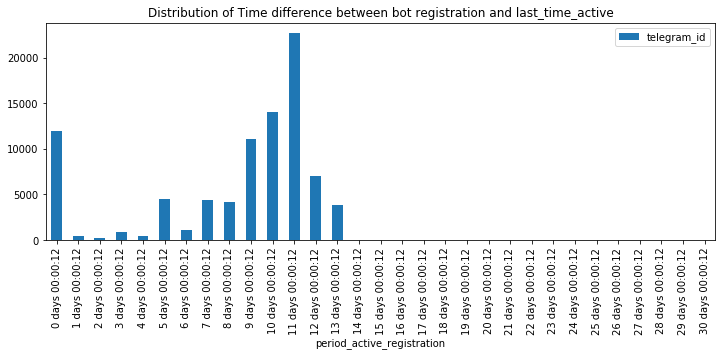

In [19]:
df_join['period_active_registration'].dropna().reset_index().set_index('period_active_registration').resample("D").count().plot(kind="bar", figsize=(12,4));
plt.title("Distribution of Time difference between bot registration and last_time_active");

In [20]:
df_join[df_join['never_activated'] == 1].shape

(11721, 34)

In [21]:
df = df_join[df_join['never_activated'] == 1]
df.reset_index().groupby('email_provider').count()['telegram_id'].sort_values(ascending=False)[:5]

email_provider
163.com       11363
gmail.com       277
126.com          16
outlook.sa       12
list.ru           9
Name: telegram_id, dtype: int64

Most of them come from "163.com"

### FEATURE - "is_inactive"

Marks inactive accounts in the userbase that have not shown any activities for a long period of time, and are most likely to never come back to beeing addressable.


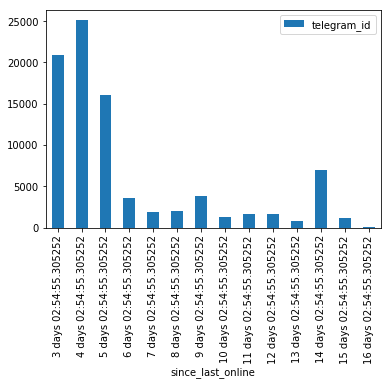

In [22]:
dist_activity = df_join['since_last_online'].reset_index().dropna().set_index('since_last_online').resample("D")
dist_activity.count().plot(kind='bar');

In [126]:
dist_activity.count()['telegram_id'].values[:4].sum()

65464

### FEATURE - "Duplicated Wallets"

Analyzes if a given ether wallet is registered with multiple accounts, if so they are removed

In [117]:
# Visualization fill out later

87478

### FEATURE - "outlier_registration_time"

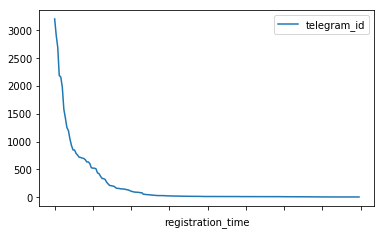

In [39]:
df_join['registration_time'].reset_index().dropna().set_index('registration_time').resample('S').count().sort_values('telegram_id', ascending=False)[:200].plot();

In [24]:
# Setting the quantile to select the fastest signups
quantile_val = df_join['registration_time'].quantile(0.2)
quantile_val

Timedelta('0 days 00:00:12.515600')

In [25]:
df_join[df_join['registration_time'] < quantile_val ].shape

(13902, 34)

### FEATURE - "suspicious_mail"
Identify patterns of email addresses that might be linked to a 

## Restricting users in the Airdrop

In [ ]:
# Generate the necessary features in the dataset

In [ ]:
# Label the dataset

In [28]:
# Generate an exclusion list that can be used to expell users

### Extraction markers

List of reasons to be excluded from the chat:
* Have registered with the bot, but did not get verified
* Have registered the account with a duplicate ether wallet
* Have registered but not provided eth and email address
* Account has been deleted
* Have an email pattern indicative of a bot net (Might need verification by external mail verification service to be certain)

In [157]:
# Set is_banned flag for "not verified signups"
not_verified_signups = df_join['verified'].isna()
df_join.loc[not_verified_signups, ['is_banned']]= 1
df_join.loc[not_verified_signups,['reason_banned']] = "unverified signup"

# Missing wallet
missing_email = df_join['ethaddress'].isna()
df_join.loc[not_verified_signups, ['is_banned']] = 1
df_join.loc[not_verified_signups, ['reason_banned']] = 'missing wallet address'

# "Duplicated ether wallet"
df_join.reset_index(inplace=True)
for id in telegram_ids_duplicate_accounts:
    df_join.loc[df_join['telegram_id'] == id, 'is_banned'] = 1
    df_join.loc[df_join['telegram_id'] == id, 'reason_banned'] = 'Duplicate account'

In [179]:
# Ban accounts that have registered within less than 5 sec after joining
df_join.set_index('delta_registration').isna().sum()

telegram_id                0
registered_at              0
joined_channel_at      62568
verified               16285
username               63120
name                   62568
first_name             16051
last_name              26205
email                      0
email_name                 0
email_provider             0
ethaddress             17428
deleted                14807
is_online              14807
recently_online        14807
last_online            16942
since_last_online      16942
delta_registrationn    62568
is_banned                  0
duplicat_wallet            0
reason_banned          86616
dtype: int64

##### Adapt the New column to be categorical for easier plotting

In [41]:
# Adapt the new column types
df_join['reason_banned'] = df_join['reason_banned'].astype('category')

Check the amount of people that have been set as to be banned

In [ ]:
sum(df_join['is_banned']==1)

### Analyzing activity patterns over time

In [ ]:
# Analyze how long users have not been active on Telegram that registered to our Airdrop
df_join['since_last_online'].dropna().sort_values(ascending=False).to_frame().reset_index().set_index('since_last_online').resample("D").count()[:10]

In [161]:
import datetime
short_signup = df_join['joined_channel_at'] + datetime.timedelta(seconds=5) 
df_join['delta_registration'] = df_join['joined_channel_at'] - df_join['registered_at']

In [164]:
len(0 < df_join[df_join['delta_registration'] < datetime.timedelta(seconds=5)])

18794

## Analyzing patterns in the email providers

In order to identify what patterns each of the individual providers had, i will try to seperate out the likely bot net providers from the ones we have no reason to suspect botnets to come from.

In [151]:
provider = "163.com"
df = df_join[df_join['email_provider'] == provider]

lets check for duplicates and missing unverified accounts

In [144]:
# Correctly verified
verified_accounts = df[-df['verified'].isna()]
print("We have {} verified accounts. {:.2f}%".format(len(verified_accounts), len(verified_accounts) / len(df) *100))

# Unverified accounts
unverified_accounts = df[df['verified'].isna()]
print("We have {} unverified accounts. {:.2f}%".format(len(unverified_accounts), len(unverified_accounts) / len(df) * 100))

We have 47468 verified accounts. 78.15%
We have 13268 unverified accounts. 21.85%
